In [1]:
import warnings; warnings.simplefilter('ignore')

import sys
sys.path.insert(0, '/home/jcbyts/Repos/')

import Utils as U
import gratings as gt



import NDN3.NDNutils as NDNutils

which_gpu = NDNutils.assign_gpu()

import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

from scipy.ndimage import gaussian_filter
from copy import deepcopy

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt  # plotting
import seaborn as sns

import NDN3.NDN as NDN
import NDN3.Utils.DanUtils as DU

*******************************************************************************************
---> getting list of available GPUs:
[0, 1]

---> getting GPU memory map:
{0: 758, 1: 3357}

---> setting up GPU with largest available memory:
   ...picking GPU # 0
*******************************************************************************************

Done!


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

# reload grating.py if you edited it
import importlib
importlib.reload(gt)

indexlist = [17]
matdat = gt.load_data(indexlist[0])

In [3]:
# load and process
indexlist = [5]
stim, sacon, sacoff, RobsAll, DF, basis, opts, sacbc, valid, eyepos = gt.load_and_setup(indexlist,npow=1.8)
RobsAll = RobsAll.astype('float32')

# # valid indices
Ui = opts['Ui']
Xi = opts['Xi']
Tiv = np.intersect1d(opts['Ti'], np.where(valid)[0])

# need to include invalid indices for frozen trials
Ti = opts['Ti']

print('%02.2f minutes of usable data' %(sum(valid)/opts['frate']/60))

ellie_20170801
maxmium SF: 14.17
17.14 minutes of usable data


In [4]:
adam_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True}, learning_alg='adam')

early_stopping = 100

adam_params['batch_size'] = 1000
adam_params['display'] = 30
adam_params['MAPest'] = True
adam_params['epochs_training'] = 1000
adam_params['early_stop'] = early_stopping
adam_params['early_stop_mode'] = 1
adam_params['epsilon'] = 1e-8
adam_params['data_pipe_type'] = 'data_as_var' # 'feed_dict'
adam_params['learning_rate'] = 1e-3

lbfgs_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True, 'display': True}, learning_alg='lbfgs')
lbfgs_params['maxiter'] = 10000

noise_dist = 'poisson'
seed = 5
optimizer = 'lbfgs'


if noise_dist=='poisson':
    null_adjusted = True
else:
    null_adjusted = False

if optimizer=='adam':
    opt_params = adam_params
else:
    opt_params = lbfgs_params

In [5]:
# fit stimulus model and remove bad units
num_tkerns = 3
num_lags = 15
NX = opts['NX']
NY = opts['NY']
NC = RobsAll.shape[1]

glm_par = NDNutils.ffnetwork_params(
    input_dims=[1,NX,NY], time_expand=[num_lags],
    layer_sizes=[num_tkerns, NC],
    layer_types=['temporal', 'normal'], # readout for cell-specific regularization
    act_funcs=['lin', 'softplus'],
    normalization=[1, 0],
    reg_list={'d2t': [1e-5], 'd2x': [None,1e-5], 'l2':[1e-6,1e-6]}
)

glm = NDN.NDN([glm_par], tf_seed=seed, noise_dist=noise_dist)

_ = glm.train(input_data=[stim], output_data=RobsAll, train_indxs=Ui, test_indxs=Xi,
    learning_alg=optimizer, opt_params=opt_params, use_dropout=False)

print("Done Training Initial Model")

W0630 10:53:43.187260 140463242524480 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:270: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0630 10:53:43.188725 140463242524480 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:278: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

W0630 10:53:43.189733 140463242524480 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:281: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0630 10:53:43.190661 140463242524480 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:1108: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 10:53:43.200186 140463242524480 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/layer.py:236: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead

Input dimensions: [1, 8, 6]
0: temporal (lin):  	[E3/I0] N
1: normal (softplus):  	[E15/I0] 


W0630 10:53:43.471154 140463242524480 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0630 10:53:43.521970 140463242524480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0630 10:53:43.571605 140463242524480 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:359: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0630 10:53:43.58

Done Training Initial Model


In [6]:
LLx0 = glm.eval_models(input_data=[stim], output_data=RobsAll, data_indxs=Xi, nulladjusted=True)

cids = LLx0>0.01
print("%d/%d units better than null model" %(np.sum(cids), len(LLx0)))
Robs = RobsAll[:,cids].copy()


W0630 10:56:47.652888 140463242524480 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:1252: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



11/15 units better than null model


## Fit GLM stimulus model (good units only)

In [7]:
num_lags = 15
NX = opts['NX']
NY = opts['NY']
NT,NC=Robs.shape
print("%d Time points, %d Neurons" %(NT, NC))

glm_par = NDNutils.ffnetwork_params(
    input_dims=[1,NX,NY], time_expand=[num_lags],
    layer_sizes=[num_tkerns, NC],
    layer_types=['temporal', 'normal'], # readout for cell-specific regularization
    act_funcs=['lin', 'softplus'],
    normalization=[1, 0],
    reg_list={'d2t': [1e-5], 'd2x': [None,1e-4], 'l2':[1e-6,1e-6]}
)

glm = NDN.NDN([glm_par], tf_seed=seed, noise_dist=noise_dist)

_ = glm.train(input_data=[stim], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
    learning_alg=optimizer, opt_params=opt_params, use_dropout=False)

print("Done Training Initial Model")

LLx0 = glm.eval_models(input_data=[stim], output_data=Robs, data_indxs=Xi, nulladjusted=null_adjusted)


174443 Time points, 11 Neurons
Input dimensions: [1, 8, 6]
0: temporal (lin):  	[E3/I0] N
1: normal (softplus):  	[E11/I0] 
Done Training Initial Model


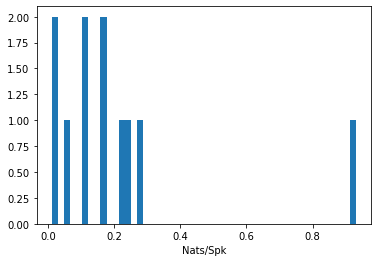

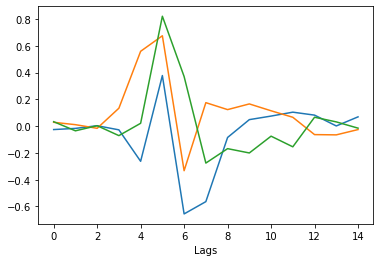

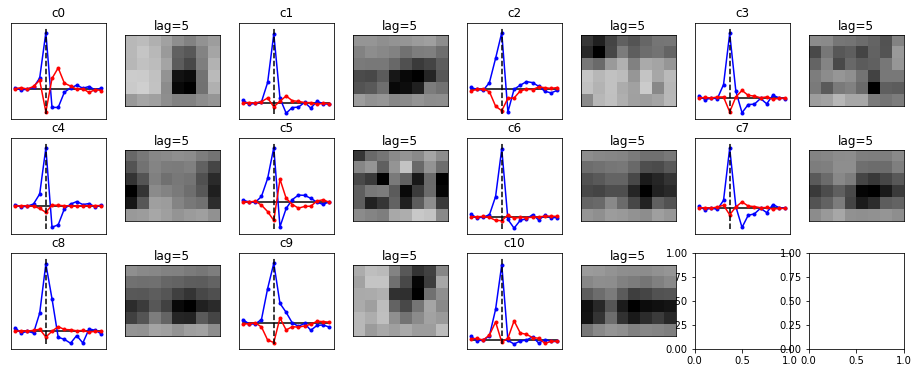

In [8]:

LLx0 = glm.eval_models(input_data=[stim], output_data=Robs, data_indxs=Xi, nulladjusted=null_adjusted)

RpredG = glm.generate_prediction(input_data=[stim])

g0 = glm.generate_prediction(input_data=[stim], pre_activation=True)

plt.figure()
plt.hist(LLx0, 50)
plt.xlabel('Nats/Spk')
    
plt.figure()
plt.plot(glm.networks[0].layers[0].weights)
plt.xlabel("Lags")

DU.plot_3dfilters(glm)

In [12]:
mu = opts['rf']['mu']
mu.shape

(2, 1)

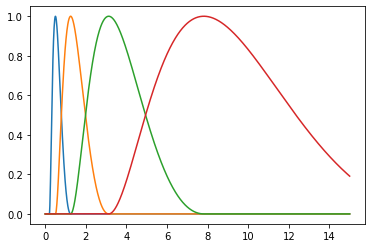

In [13]:
def cart2pol(x, y):
    rho = np.hypot(x,y)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

num_onlags = 42
num_offlags = 42
back_shiftson = 40
back_shiftsoff = 2

ixon = np.where(np.diff(sacbc, axis=0)==1)[0]
ixoff = np.where(np.diff(sacbc, axis=0)==-1)[0]

sacon = np.append(0, np.diff(sacbc, axis=0)==1).astype('float32')
sacoff = np.append(0, np.diff(sacbc, axis=0)==-1).astype('float32')


dx = eyepos[ixoff,1]-eyepos[ixon,1]
dy = eyepos[ixoff,2]-eyepos[ixon,2]

[sacAmp, th] = cart2pol(dx, dy)

mu = opts['rf']['mu'].flatten()

sigma = .5

from scipy.stats import multivariate_normal

# get the saccade 
x = np.concatenate([[dx], [dy]]).T
mvn = multivariate_normal(mu, opts['rf']['cov'])
sacInRF = mvn.pdf(x)

# project saccade size on a tent basis
nSacBasis = 4
bax = np.linspace(0,15,1000)
sB = gt.raised_cosine(bax,nSacBasis,0.5,2.5)
plt.plot(bax, sB)

sacOnAmp = sacon.copy()
sacOnAmp[np.where(sacon)[0]] = sacAmp
sacOnAmp = gt.raised_cosine(sacOnAmp,nSacBasis,0.5,2.5)

sacOffAmp = sacoff.copy()
sacOffAmp[np.where(sacoff)[0]] = sacAmp
sacOffAmp = gt.raised_cosine(sacOffAmp, nSacBasis, 0.5, 2.5)
# sacOffAmp = np.expand_dims(sacOffAmp, axis=1)

sacin = sacon.copy()
sacin[ixon+1] = sacInRF
sacout = sacon.copy()
sacout[ixon+1] = 1 - sacInRF
sacin = np.expand_dims(sacin,axis=1)
sacout = np.expand_dims(sacout,axis=1)

sacoutoff = sacoff.copy()
sacoutoff[ixoff+1] = 1 - sacInRF
sacoutoff = np.expand_dims(sacoutoff,axis=1)

sacon = np.expand_dims(sacon, axis=1)
sacoff = np.expand_dims(sacoff, axis=1)

# saccade onset/offset with back_shifts
saconshift = NDNutils.shift_mat_zpad(sacon,-back_shiftson,dim=0)

sacinshift = NDNutils.shift_mat_zpad(sacin,-back_shiftson,dim=0)
sacoutshift = NDNutils.shift_mat_zpad(sacout,-back_shiftson,dim=0)

sacOnAmpshift = NDNutils.shift_mat_zpad(sacOnAmp,-back_shiftson,dim=0)
sacOffAmpshift = NDNutils.shift_mat_zpad(sacOffAmp,-back_shiftsoff,dim=0)

tspacing = list(np.concatenate([np.arange(0,20,5), np.arange(20,40,3), np.arange(40,42,1)]))
tspacingoff = list(np.concatenate([np.arange(0,20,1), np.arange(20,42,3)]))


sacOnAmpshift[np.sum(np.isnan(sacOnAmpshift),axis=1)>0,:] = 0
sacOffAmpshift[np.sum(np.isnan(sacOffAmpshift),axis=1)>0,:] = 0

Text(0.5, 0, 'Fixation Duration (Bins)')

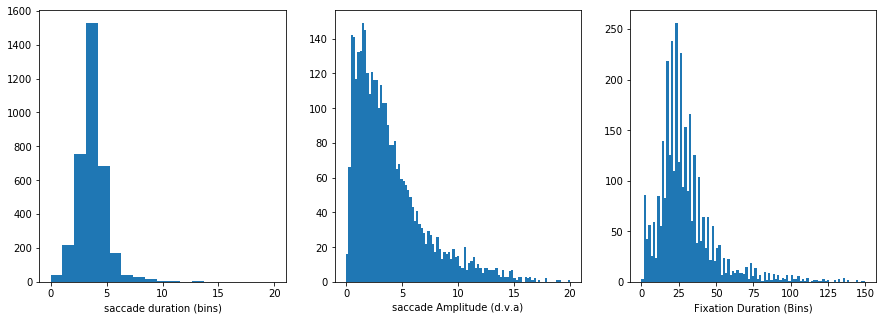

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
f = plt.hist(ixoff-ixon, bins=np.linspace(0, 20,20))
plt.xlabel('saccade duration (bins)')
plt.subplot(1,3,2)
f = plt.hist(sacAmp, bins=np.linspace(0, 20,100))
plt.xlabel('saccade Amplitude (d.v.a)')

plt.subplot(1,3,3)
f = plt.hist(ixon[1:]-ixoff[:-1], bins=np.linspace(0, 150,100))
plt.xlabel('Fixation Duration (Bins)')



In [15]:
# summarize data 


nlags = 100
Xsacon = NDNutils.create_time_embedding( sacOnAmpshift, [nlags, 1, nSacBasis], tent_spacing=1)

cc=0

In [16]:

Xsacon[np.sum(np.isnan(Xsacon), axis=1)>0,:] = 0


Text(0.5, 1.0, '5')

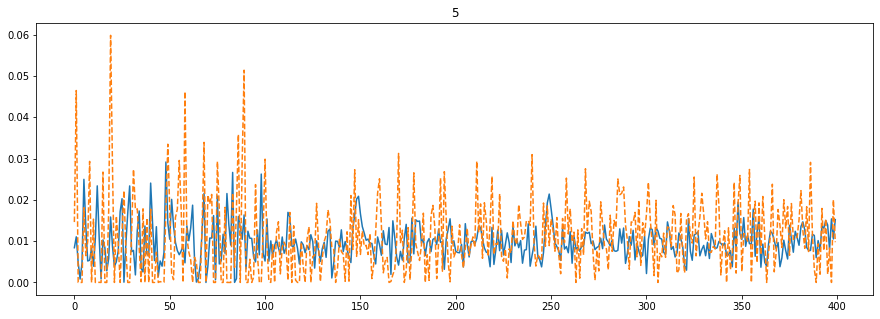

In [21]:
cc += 1
if cc >= Robs.shape[1]:
    cc = 0

rmult = np.expand_dims(Robs[:,cc], axis=1)*Xsacon

plt.figure(figsize=(15,5))

plt.plot(np.sum(rmult[Ui,:], axis=0)/np.sum(Xsacon[Ui,:], axis=0))
plt.plot(np.sum(rmult[Xi,:], axis=0)/np.sum(Xsacon[Xi,:], axis=0), '--')

    

    
plt.title(cc)



In [22]:
glm.network_list[0]

glm_par

{'network_type': 'normal',
 'xstim_n': [0],
 'ffnet_n': None,
 'input_dims': [1, 8, 6],
 'layer_sizes': [3, 11],
 'layer_types': ['temporal', 'normal'],
 'activation_funcs': ['lin', 'softplus'],
 'normalize_weights': [1, 0],
 'time_expand': [15, 0],
 'reg_initializers': [{'d2t': 1e-05, 'l2': 1e-06},
  {'d2x': 0.0001, 'l2': 1e-06}],
 'weights_initializers': ['normal', 'normal'],
 'num_inh': [0, 0],
 'pos_constraints': [None, None],
 'log_activations': False,
 'conv_filter_widths': [None, None],
 'shift_spacing': [1, 1],
 'dilation': [1, 1]}

Input dimensions: [1, 1, 1]
0: temporal (lin):  	[E3/I0] N
1: normal (lin):  	[E11/I0] 
Input dimensions: [1, 1, 1]
0: normal (lin):  	[E11/I0] 
Input dimensions: [1, 1, 4]
0: temporal (lin):  	[E3/I0] N
1: normal (lin):  	[E3/I0] N
2: normal (lin):  	[E11/I0] 
0: add (softplus):  	[E11/I0] 
  Temporal layer: updating number of weights in temporal layer from 42 to 13.
  Temporal layer: updating number of weights in temporal layer from 42 to 28.


Text(0.5, 1.0, 'Sac Offset Basis')

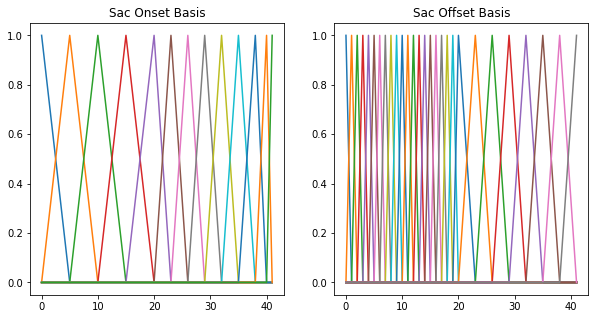

In [23]:
# saccade modulation model is shared
num_durlags = 2
num_sacsubs = 3
num_sactkerns = 3

stim_par = glm_par.copy()  # copy the stimulus parameters from the GLM
stim_par['activation_funcs'][-1] = 'lin' # switch to linear activation, softplus will still be on the output

# sac onset in RF 
# sac_on_par = NDNutils.ffnetwork_params(
#     input_dims=[1,1,1],
#     time_expand=[num_onlags],
#     xstim_n=[1],
#     layer_sizes=[num_sactkerns, num_sacsubs, NC],
#     layer_types=['temporal', 'normal', 'normal'],
#     act_funcs=['lin', 'lin', 'lin'],
#     normalization=[1, 1, 0], #? check normalization in last layer
#     reg_list={'d2t':[0.01],'l2':[None, 1e-5], 'l1':[None]})

# sac_on_par = NDNutils.ffnetwork_params(
#     input_dims=[1,1,1],
#     time_expand=[num_onlags],
#     xstim_n=[1],
#     layer_sizes=[num_sactkerns, num_sacsubs, NC], # conv_filter_widths=[1],
#     layer_types=['temporal', 'normal', 'normal'],
#     act_funcs=['lin', 'lin', 'lin'],
#     normalization=[1, 1, 0],
#     reg_list={'orth':[1e-1,1e-1], 'd2t':[1e-2],'d2x':[None, None],'l2':[None], 'l1':[None]})
sac_on_par = NDNutils.ffnetwork_params(
    input_dims=[1,1,1],
    time_expand=[num_onlags],
    xstim_n=[1],
    layer_sizes=[num_sactkerns, NC], # conv_filter_widths=[1],
    layer_types=['temporal', 'normal'],
    act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'orth':[1e-1,None], 'd2t':[1e-1],'d2x':[None, None],'l2':[None], 'l1':[None]})

sac_dur_par = NDNutils.ffnetwork_params(
    input_dims=[1,1,1],
    xstim_n=[3],
    layer_sizes=[NC], # conv_filter_widths=[1],
    layer_types=['normal'],
    act_funcs=['lin'],
    normalization=[0],
    reg_list={'d2t':[None],'d2x':[None],'l2':[1e-3], 'l1':[1e-5]})

sac_off_par = NDNutils.ffnetwork_params(
    input_dims=[1,1,nSacBasis],
    time_expand=[num_offlags],
    xstim_n=[2],
    layer_sizes=[num_sactkerns, num_sacsubs, NC], # conv_filter_widths=[1],
    layer_types=['temporal', 'normal', 'normal'],
    act_funcs=['lin', 'lin', 'lin'],
    normalization=[1, 1, 0],
    reg_list={'orth':[1e-3,1e-3], 'd2t':[1e-1],'d2x':[None, 1],'l2':[None], 'l1':[None, None, 1e-3]})

comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[0,1,2], layer_sizes=[NC],
    layer_types=['add'], act_funcs=['softplus'])

# initialize NDN
ndn2 = NDN.NDN([stim_par, sac_on_par, sac_off_par, sac_dur_par, comb_par], noise_dist='poisson')
ndn2.networks[1].layers[0].init_temporal_basis( xs=tspacing )
ndn2.networks[2].layers[0].init_temporal_basis( xs=tspacingoff)

# stimulus is the same
ndn2.networks[0].layers[0].weights = deepcopy(glm.networks[0].layers[0].weights)
ndn2.networks[0].layers[0].biases = deepcopy(glm.networks[0].layers[0].biases)

# add network has 0 bias and weights 1
ndn2.networks[3].layers[0].weights /= ndn2.networks[3].layers[0].weights


# plot saccade basis
plt.figure(figsize=(10,5))
plt.subplot(121)
f = plt.plot(ndn2.networks[1].layers[0].filter_basis)
plt.title("Sac Onset Basis")
plt.subplot(122)
f = plt.plot(ndn2.networks[2].layers[0].filter_basis)
plt.title("Sac Offset Basis")

In [24]:
# Train
v2f0 = ndn2.fit_variables(layers_to_skip=[[0], [], [], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn2.train(input_data=[stim, saconshift, sacOffAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg=optimizer, opt_params=opt_params, use_dropout=False)

print("Done training additive saccade model")

Done training additive saccade model


In [25]:
# Refit all variables
v2f0 = ndn2.fit_variables(layers_to_skip=[[], [], [], [0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn2.train(input_data=[stim, saconshift, sacOffAmpshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg=optimizer, opt_params=opt_params, use_dropout=False)

print("Done training additive saccade model")

Done training additive saccade model


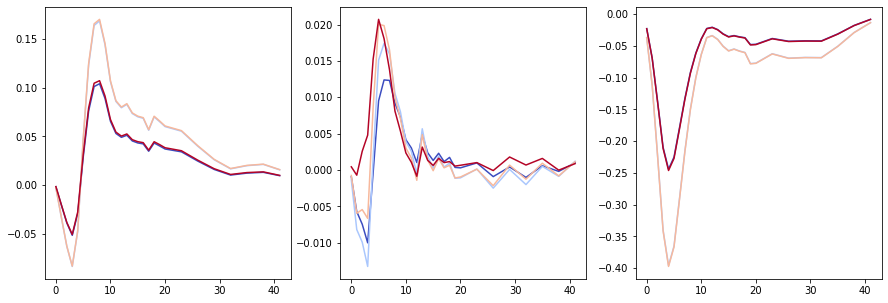

In [26]:
# def get_saccade_kernel(ndn_mod, ffnet=1):
ndn_mod = ndn2.copy_model()
ffnet = 2

filters = DU.compute_spatiotemporal_filters(ndn_mod, ffnet=ffnet)
if len(filters.shape)>3:
    filters = np.squeeze(filters)

w = np.transpose(filters, [1,0,2]);


cm = plt.cm.coolwarm(np.linspace(0, 1, nSacBasis))
plt.figure(figsize=(15,5))
for j in range(num_sacsubs):
    plt.subplot(1,num_sacsubs,j+1)
    for i in range(w.shape[1]):
        plt.plot(w[:,i,j], color=cm[i])


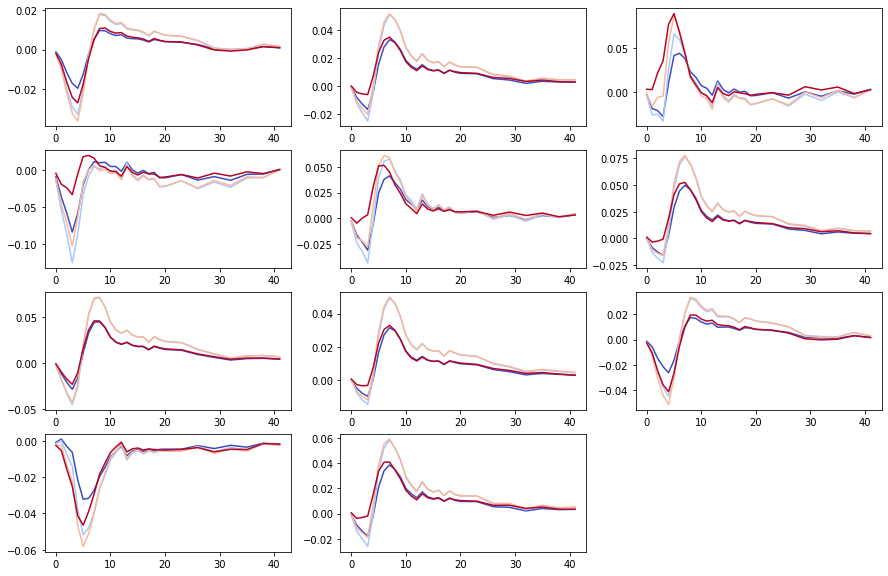

In [27]:
ffnet = 2
filters = DU.compute_spatiotemporal_filters(ndn_mod, ffnet=ffnet)
if len(filters.shape)>3:
    filters = np.squeeze(filters)

w = np.transpose(filters, [1,0,2]);

w2 = np.reshape(w, [-1,num_sacsubs])@ndn_mod.networks[ffnet].layers[2].weights
nb = w.shape[1]
w2 = np.reshape(w2, [-1, nb, NC])

plt.figure(figsize=(15,10))
sx,sy = U.get_subplot_dims(NC)
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    for i in range(nb):
        plt.plot(w2[:,i,cc], color=cm[i])

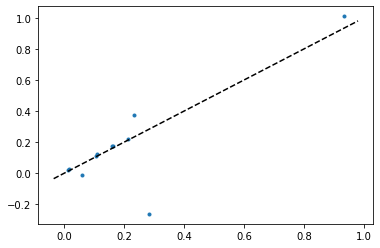

In [28]:
glm.time_spread=ndn2.time_spread
LLx0 = glm.eval_models(input_data=[stim],output_data=Robs, data_indxs=Xi, nulladjusted=True)
LLx1 = ndn2.eval_models(input_data=[stim, saconshift, sacOffAmpshift], output_data=Robs, data_indxs=Xi, nulladjusted=True)

plt.plot(LLx0, LLx1, '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')

In [62]:
# multiplicative model

stim_par = glm_par.copy()  # copy the stimulus parameters from the GLM
stim_par['activation_funcs'][-1] = 'lin' # switch to linear activation, softplus will still be on the output

sac_in_par = NDNutils.ffnetwork_params(
    input_dims=[1,1,1], time_expand=[num_onlags],
    xstim_n=[1],
    layer_sizes=[2, NC],
    layer_types=['temporal', 'normal'], act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'d2t':[0.1],'l2':[None], 'l1':[None]})

sac_out_par = NDNutils.ffnetwork_params(
    input_dims=[1,1,1], time_expand=[num_onlags],
    xstim_n=[2],
    layer_sizes=[2, NC],
    layer_types=['temporal', 'normal'], act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'d2t':[0.01],'l2':[None], 'l1':[None]})


sac_off_par = NDNutils.ffnetwork_params(
    input_dims=[1,1,1], time_expand=[num_offlags],
    xstim_n=[3],
    layer_sizes=[2, NC],
    layer_types=['temporal', 'normal'], act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'d2t':[0.01],'l2':[None], 'l1':[None]})

# sac_dur_par = NDNutils.ffnetwork_params(
#     input_dims=[1,1,1], time_expand=[num_durlags],
#     xstim_n=[1],
#     layer_sizes=[2, NC],
#     layer_types=['temporal', 'normal'], act_funcs=['lin', 'lin'],
#     normalization=[1, 0],
#     reg_list={'d2t':[0.01],'l2':[None], 'l1':[None]})

mult_par_in = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[0,1], layer_sizes=[NC],
    layer_types=['add'], act_funcs=['lin'])

mult_par_out = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[0,2], layer_sizes=[NC],
    layer_types=['mult'], act_funcs=['lin'])

comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[3,4,5], layer_sizes=[NC],
    layer_types=['add'], act_funcs=['softplus'])

# initialize NDN
ndn3 = NDN.NDN([stim_par, sac_in_par, sac_out_par, sac_off_par, mult_par_in, mult_par_out, comb_par], noise_dist='poisson')
ndn3.networks[1].layers[0].init_temporal_basis( xs=tspacing )
ndn3.networks[2].layers[0].init_temporal_basis( xs=tspacingoff)
# ndn3.networks[3].layers[0].init_temporal_basis( xs=tspacingoff)

# initialize saccade combination weights to 1.0
ndn3.networks[1].layers[1].weights /= ndn3.networks[1].layers[1].weights
ndn3.networks[2].layers[1].weights /= ndn3.networks[2].layers[1].weights
ndn3.networks[3].layers[1].weights /= ndn3.networks[3].layers[1].weights

# stimulus is the same
ndn3.networks[0].layers[0].weights = deepcopy(glm.networks[0].layers[0].weights)
ndn3.networks[0].layers[0].biases = deepcopy(glm.networks[0].layers[0].biases)
ndn3.networks[0].layers[1].weights = deepcopy(glm.networks[0].layers[1].weights)
ndn3.networks[0].layers[1].biases = deepcopy(glm.networks[0].layers[1].biases)

# add/mult network has 0 bias and weights 1
ndn3.networks[4].layers[0].weights /= ndn3.networks[4].layers[0].weights
ndn3.networks[5].layers[0].weights /= ndn3.networks[5].layers[0].weights
ndn3.networks[6].layers[0].weights /= ndn3.networks[6].layers[0].weights

Input dimensions: [1, 1, 1]
0: temporal (lin):  	[E2/I0] N
1: normal (lin):  	[E18/I0] 
Input dimensions: [1, 1, 1]
0: temporal (lin):  	[E2/I0] N
1: normal (lin):  	[E18/I0] 
Input dimensions: [1, 1, 1]
0: temporal (lin):  	[E2/I0] N
1: normal (lin):  	[E18/I0] 
0: add (lin):  	[E18/I0] 
0: mult (lin):  	[E18/I0] 
0: add (softplus):  	[E18/I0] 
  Temporal layer: must expand temporal basis from 69 to 70.
  Temporal layer: updating number of weights in temporal layer from 70 to 28.
  Temporal layer: must truncate temporal basis from 76 to 70.
  Temporal layer: updating number of weights in temporal layer from 70 to 29.


In [63]:
v2f0 = ndn3.fit_variables(layers_to_skip=[[0,1], [], [], [], [0],[0],[0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn3.train(input_data=[stim, sacinshift, sacoutshift, sacoutoffshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='adam', opt_params=adam_params, use_dropout=False)

Epoch 0000:  avg train cost =     8.2748,  avg test cost =     8.6205,  reg penalty =     0.0634
Epoch 0029:  avg train cost =     7.0405,  avg test cost =     7.3069,  reg penalty =     0.0198
Epoch 0059:  avg train cost =     6.7192,  avg test cost =     7.0167,  reg penalty =     0.0189
Epoch 0089:  avg train cost =     6.5672,  avg test cost =     6.8690,  reg penalty =     0.0181
Epoch 0119:  avg train cost =     6.5064,  avg test cost =     6.7970,  reg penalty =     0.0175
Epoch 0149:  avg train cost =     6.4816,  avg test cost =     6.7793,  reg penalty =     0.0171
Epoch 0179:  avg train cost =     6.4669,  avg test cost =     6.7600,  reg penalty =     0.0167
Epoch 0209:  avg train cost =     6.4546,  avg test cost =     6.7624,  reg penalty =     0.0165
Epoch 0239:  avg train cost =     6.4442,  avg test cost =     6.7526,  reg penalty =     0.0163
Epoch 0269:  avg train cost =     6.4348,  avg test cost =     6.7364,  reg penalty =     0.0161
Epoch 0299:  avg train cost = 

In [50]:
v2f0 = ndn3.fit_variables(layers_to_skip=[[], [], [], [], [0], [0],[0]], fit_biases=False)
v2f0[-1][-1]['biases']=True

_ = ndn3.train(input_data=[stim, sacinshift, sacoutshift, sacoutoffshift], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
        fit_variables=v2f0,
        learning_alg='adam', opt_params=adam_params, use_dropout=False)

Epoch 0000:  avg train cost =     5.3609,  avg test cost =     5.5715,  reg penalty =     0.0151
Epoch 0029:  avg train cost =     5.3573,  avg test cost =     5.5707,  reg penalty =     0.0149
Epoch 0059:  avg train cost =     5.3553,  avg test cost =     5.5737,  reg penalty =     0.0147
Epoch 0089:  avg train cost =     5.3526,  avg test cost =     5.5707,  reg penalty =     0.0146

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 102,  end cost: 100.547476
     ---> best epoch: 93,  best cost: 100.479467



In [64]:
skin = ndn3.networks[1].layers[0].filter_basis@ndn3.networks[1].layers[0].weights
skout = ndn3.networks[2].layers[0].filter_basis@ndn3.networks[2].layers[0].weights

skoff = ndn3.networks[3].layers[0].filter_basis@ndn3.networks[3].layers[0].weights
dt = 8

w1 = ndn3.networks[1].layers[1].weights
w2 = ndn3.networks[2].layers[1].weights
w3 = ndn3.networks[3].layers[1].weights


plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
f = plt.plot(dt*np.arange(0, skin.shape[0], 1), skin@w1, 'k')
plt.plot(np.array(tspacing)*dt, ndn3.networks[1].layers[0].weights@w1, '.')
plt.plot([back_shiftson*dt,back_shiftson*dt], plt.ylim(), 'r')
plt.xlabel("ms")

plt.subplot(1,3,2)
f = plt.plot(dt*np.arange(0, skout.shape[0], 1), skout@w2, 'k')
plt.plot(np.array(tspacing)*dt, ndn3.networks[2].layers[0].weights@w2, '.')
plt.plot([back_shiftson*dt,back_shiftson*dt], plt.ylim(), 'r')
plt.xlabel("ms")
# plt.title("")

plt.subplot(1,3,3)
f = plt.plot(dt*np.arange(0, skoff.shape[0], 1), skoff@w3, 'k')
plt.plot(np.array(tspacingoff)*dt, ndn3.networks[3].layers[0].weights@w3, '.')
plt.plot([back_shiftsoff*dt,back_shiftsoff*dt], plt.ylim(), 'r')
plt.xlabel("ms")

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

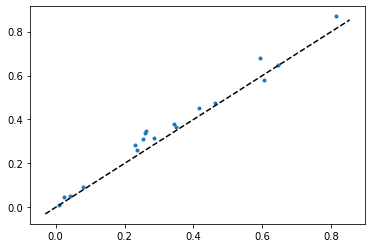

In [52]:
glm.time_spread=ndn3.time_spread
LLx0 = glm.eval_models(input_data=[stim],output_data=Robs, data_indxs=Ti, nulladjusted=True)
LLx1 = ndn3.eval_models(input_data=[stim, sacoutshift, sacoutoffshift], output_data=Robs, data_indxs=Ti, nulladjusted=True)

plt.plot(LLx0, LLx1, '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')

Text(0.5, 1.0, 'cell 3, r2: 0.53, 0.54')

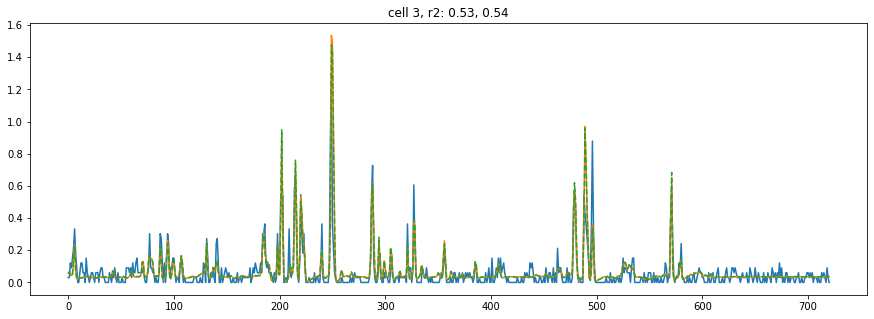

In [54]:
Rpred0 = glm.generate_prediction(input_data=[stim])
Rpred1 = ndn2.generate_prediction(input_data=[stim, sacinshift, sacoutshift])

plt.figure(figsize=(15,5))
cc = 3
Ti = opts['Ti']
r = np.reshape(Robs[Ti,cc], (opts['num_repeats'],-1))
r0 = np.reshape(Rpred0[Ti,cc], (opts['num_repeats'],-1))
r1 = np.reshape(Rpred1[Ti,cc], (opts['num_repeats'],-1))
r = np.average(r, axis=0)
r0 = np.average(r0, axis=0)
r1 = np.average(r1, axis=0)
plt.plot(r)
plt.plot(r0, '-')
plt.plot(r1, '--')

r20 = U.r_squared(np.reshape(r, (-1,1)), np.reshape(r0, (-1,1)))
r21 = U.r_squared(np.reshape(r, (-1,1)), np.reshape(r1, (-1,1)))

plt.title("cell %d, r2: %0.2f, %0.2f" %(cc,r20, r21))


## Why is the green trace so far off? I clearly don't understand how the add layer works

## Train

In [7]:

# g0 = glm.generate_prediction(input_data=[stim], pre_activation=True)

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

i = 0

array([8.])

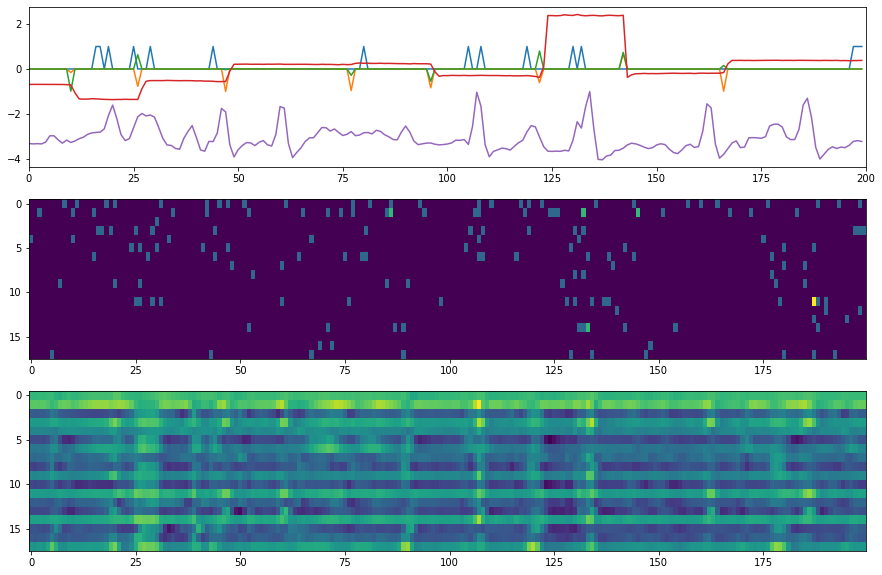

In [67]:
# i += 500

ix = np.arange(i, i+200, 1)
ix = Ui[ix]
plt.figure(figsize=(15,10))
plt.subplot(311)
f=plt.plot(Robs[ix,cc])
th,rho = cart2pol(eyepos[ix,1:2], eyepos[ix,2:3])
f=plt.plot(sacon[ix]*np.cos(th))
f=plt.plot(sacon[ix]*np.sin(th))
plt.plot(rho)
plt.plot(g0[ix,cc])
plt.xlim([0, 200])
plt.subplot(312)
plt.imshow(Robs[ix,:].T, aspect='auto')
plt.subplot(313)
plt.imshow(g0[ix,:].T, aspect='auto')

sum(sacon[ix])
# plt.plot(eyepos[ix,1])

(array([7.7101e+04, 0.0000e+00, 0.0000e+00, 3.4671e+04, 0.0000e+00,
        0.0000e+00, 1.0250e+03, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

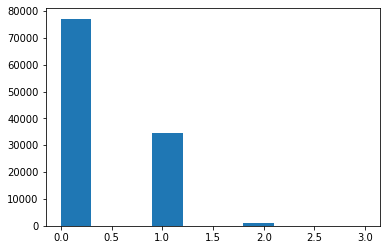

In [8]:
from scipy.ndimage import convolve1d
x = sacon.astype('float')
y = convolve1d(x, np.ones(10), axis=0)
h = plt.hist(y)

NameError: name 'Rpred0' is not defined

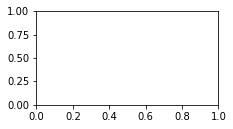

In [114]:
ev = np.where(sacon)[0]

win = [-40,40]
NC = Robs.shape[1]
sx,sy = U.get_subplot_dims(NC)
plt.figure(figsize=(15,10))
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    m,xax,wf = gt.psth(Robs[:,cc], ev, win[0], win[1])
    m0,xax,wf0 = gt.psth(Rpred0[:,cc], ev, win[0], win[1])
    m1,xax,wf1 = gt.psth(Rpred1[:,cc], ev, win[0], win[1])
    
#     plt.plot(xax, np.std(wf, axis=0), 'k')
#     plt.plot(xax,np.std(wf0, axis=0))
#     plt.plot(xax,np.std(wf1, axis=0))
    
    plt.plot(xax, m, 'k')
    plt.plot(xax,m0)
    plt.plot(xax,m1)

sns.despine(offset=0, trim=True)

### Spent some time trying to diagnose belew, but didn't get anywhere

In [25]:
cc = 2
nbins = 50
def empiricalNonlinearity(g, r, nbins=50):
    if type(nbins)!=int:
        binEdges = nbins
        nbins = len(binEdges)
    else:    
        binEdges = np.percentile(g, np.linspace(0, 100, nbins))
        
    id = np.digitize(g, binEdges)
    spkNL = np.zeros(nbins)
    for i in range(nbins):
        spkNL[i]=np.average(r[id==i])
    return spkNL,binEdges

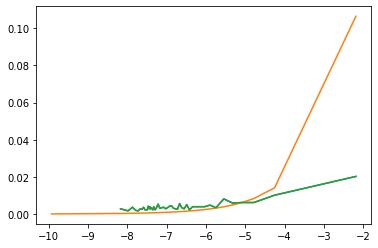

In [26]:
cc += 1
spkNL,binEdges = empiricalNonlinearity(g0[:,cc], Robs[:,cc])

plt.plot(binEdges, spkNL)
plt.plot(binEdges, np.log(1 + np.exp(binEdges)))

spkNL,binEdges = empiricalNonlinearity(g0[:,cc], Robs[:,cc], nbins=binEdges)    
plt.plot(binEdges, spkNL)

In [27]:
cc=3
Ti = opts['Ti']
r = np.reshape(Robs[Ti,cc], (opts['num_repeats'],-1))
r0 = np.reshape(Rpred1[Ti,cc], (opts['num_repeats'],-1))
r = np.average(r, axis=0)
r0 = np.average(r0, axis=0)
plt.plot(r)
plt.plot(r0)
plt.title("cell %d" %cc)
U.r_squared(np.reshape(r, (-1,1)), np.reshape(r0, (-1,1)))

KeyError: 'num_repeats'

In [28]:
g0 = glm.generate_prediction(input_data=[stim], pre_activation=True)

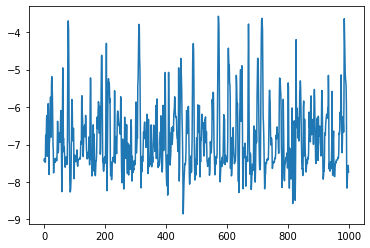

In [29]:
cc=3
plt.plot(g0[1:1000,cc])

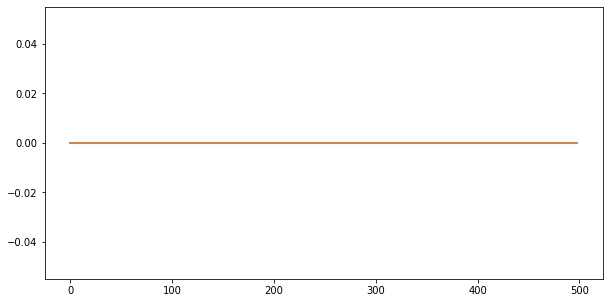

In [30]:
# check that saccade alignment works
win = [-50, 50]

# get alignment and sorting
ixon = np.where(np.diff(sacbc, axis=0)==1)[0]
ixoff = np.where(np.diff(sacbc, axis=0)==-1)[0]
tmp = np.append(0, np.diff(sacbc, axis=0)==1).astype('float')
# tmp[valid==0]=0

plt.figure(figsize=(10,5))
plt.plot(sacon[1:500])
plt.plot(tmp[1:500])
ev = ixon

sor,xax,sacs = gt.psth(sacbc.flatten(), ev, win[0], win[1])

ixd = np.argmin(np.array(xax)**2)
sor[ixd] = 0
sacs[:,ixd]=0

n=sacs.shape[0]
sortnext = np.zeros(n)
sortprev = np.zeros(n)
for i in range(n):
    a = sacs[i,:ixd]
    b = a[::-1]
    sortprev[i] = len(b) - np.argmax(b) - 1
    a = sacs[i,ixd:]
    sortnext[i] = np.argmax(a)

NameError: name 'convolve1d' is not defined

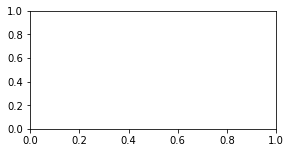

In [24]:
# saccade sorting



ixon = np.where(np.diff(sacbc, axis=0)==1)[0]
ixoff = np.where(np.diff(sacbc, axis=0)==-1)[0]
tmp = np.append(0, np.diff(sacbc, axis=0)==1).astype('float')

dx = eyepos[ixoff,1]-eyepos[ixon,1]
dy = eyepos[ixoff,2]-eyepos[ixon,2]
# plt.plot(dx, dy, '.')

[th, rho] = cart2pol(dx, dy)
ev = ixon
mu = [1.5,1.5]
sigma = .5
d = np.exp(- ((dx - mu[0])**2/2/sigma**2 + (dy - mu[1])**2/2/sigma**2))

NC = Robs.shape[1]
sx,sy = U.get_subplot_dims(NC)
plt.figure(figsize=(15,10))
for cc in range(NC):
# Robs = RobsAll.copy()
    Rsmo = Robs[:,cc].flatten()
    _,xax,wf = gt.psth(Rsmo, ev, win[0], win[1])
    
    plt.subplot(sx,sy,cc+1)
    x = np.average(wf[d<.01,:], axis=0)
    x = convolve1d(x, np.hanning(7)/7, axis=0)
    plt.plot(xax, x)
    
    x = np.average(wf[d>.05,:], axis=0)
    x = convolve1d(x, np.hanning(7)/7, axis=0)
    plt.plot(xax, x)

In [70]:
cc=2
# Robs = RobsAll.copy()
Rsmo = Robs[:,cc].flatten()
_,xax,wf = gt.psth(Rsmo, ev, win[0], win[1])
# _,_,gf = gt.psth(g0[:,cc],ev,win[0],win[1])
_,_,spdwf = gt.psth(eyepos[:,3],ev,win[0],win[1])

plt.figure(figsize=(15,5))

# plt.subplot(1,3,1)
# ind = np.argsort(np.cos(th))
ind = np.argsort(d)
# ind = np.argsort(sortprev)
# ind = np.argsort(sortnext)

# ind1 = ind[0:500]
# ind2 = ind[-500:]
plt.imshow(sacs[ind,:], aspect='auto')
plt.title("Saccades Aligned to Saccade Onset")

# plt.subplot(1,3,2)
plt.imshow(wf[ind,:]>0,aspect='auto', interpolation='bicubic')
plt.title("Binned Spikes")

plt.subplot(1,3,3)
# plt.imshow(gf[ind,:]>0,aspect='auto', interpolation='bicubic')
plt.title("Generator Signal")

# plt.subplot(1,3,3)
# plt.plot(xax, np.average(wf, axis=0)*120, 'k')
# # plt.plot(xax, np.average(wf[ind1,:], axis=0)*120)
# # plt.plot(xax, np.average(wf[ind2,:], axis=0)*120)
# plt.title(cc)
# # cc=3 # set to return to example cell
sns.despine(offset=0, trim=True)

NameError: name 'sacs' is not defined

<Figure size 1080x360 with 0 Axes>

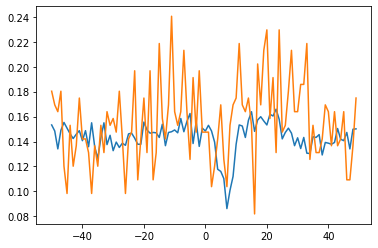

In [56]:
a = wf[ind,:]

# plt.plot(xax, np.average(a[1:1000,:], axis=0))
# plt.plot(np.average(a[500:1000,:], axis=0))
# plt.plot(xax, np.average(a[-1000:,:], axis=0))

plt.plot(xax, np.average(wf[d<.05,:], axis=0))
plt.plot(xax, np.average(wf[d>.05,:], axis=0))

In [24]:
spkNL,binEdges = empiricalNonlinearity(gf.flatten(), wf.flatten(), nbins=20)

# exclusion = [[-50, -15], [-20, 0], [-10, 10], [0, 20]]
# w = [[-20,-10],[-10,0], [0,5], [5,10]]

exlusion=[[-20, 0]]
w = [[-10,0]]
for i in range(len(w)):
    xax = np.array(xax)
    iix = np.logical_and(xax > w[i][0], xax < w[i][1])
    xix = np.logical_and(xax > exclusion[i][0], xax < exclusion[i][1])
    iiy = np.sum(spdwf[:,xix]>10, axis=1)==0
#     iiy = np.sum(sacs[:,xix]>10, axis=1)==0

    iiz = np.outer(iiy, iix)
    spkNL,binEdges = empiricalNonlinearity(gf[iiz], wf[iiz], nbins=50)
    plt.plot(binEdges, gaussian_filter(spkNL, .5))
    
# plt.plot(binEdges, np.log(1 + np.exp(binEdges)))

NameError: name 'empiricalNonlinearity' is not defined

In [162]:
w = [[-10,0], [0,5], [5,10]]
w[0]

[-10, 0]

In [ ]:
# tspaciin = np.arange

# snippet from Dan
# ndn3 = NDN.NDN([stim_par, sac_on_par, sac_off_par, sac_mid_par, comb_par], noise_dist='poisson')
# ndn3.networks[1].layers[0].init_temporal_basis( xs=tspacing )
# ndn3.networks[2].layers[0].init_temporal_basis( xs=tspacingOff )


sac_on_par = NDNutils.ffnetwork_params(
    input_dims=[1,1,1], time_expand=[num_onlags],
    xstim_n=[1],
    layer_sizes=[NC], # conv_filter_widths=[1],
    layer_types=['temporal'], act_funcs=['lin'],
    normalization=[0],
    reg_list={'d2t':[0.01],'l2':[None], 'l1':[None]})
sac_off_par = NDNutils.ffnetwork_params(
    input_dims=[1,1,1], time_expand=[num_offlags],
    xstim_n=[2],
    layer_sizes=[NC], # conv_filter_widths=[1],
    layer_types=['temporal'], act_funcs=['lin'],
    normalization=[0],
    reg_list={'d2t':[0.001],'l2':[None], 'l1':[None]})
comb_par = NDNutils.ffnetwork_params(
    xstim_n=None, ffnet_n=[0,1,2], layer_sizes=[NC],
    layer_types=['add'], act_funcs=['softplus'])

# initialize NDN
ndn2 = NDN.NDN([stim_par, sac_on_par, sac_off_par, comb_par], noise_dist='poisson')
ndn2.networks[1].layers[0].init_temporal_basis( xs=tspacing )
ndn2.networks[2].layers[0].init_temporal_basis( xs=tspacingOff )